In [1]:
import BlackScholes as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ImpliedDrift as iD
import time
import variance_curve as vc

from rbergomi import rBergomi
from matplotlib import cm

In [2]:
# Read the dataset

dates = np.array(["23_01_23.csv", "24_01_23.csv", "25_01_23.csv", "26_01_23.csv", "27_01_23.csv",
                  "30_01_23.csv", "06_02_23.csv", "13_02_23.csv", "21_02_23.csv"])

spot = np.array(pd.read_csv("spot.csv").Spot).flatten()
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])

index = 0
data = pd.read_csv(dates[index]); S0 = spot[index];
K = S0 * moneyness / 100

if index:
    maturities = np.array(data.Tenor).flatten()
    IV = np.array(data.drop(columns = ['Date', 'Tenor']))/100.

else:
    maturities = np.array(data['Exp Date']).flatten()
    IV = np.array(data.drop(columns = 'Exp Date'))/100.
    

maturities = maturities[maturities*365 <= 180]
    
nr = len(maturities); nc = len(K);

IV = IV[:nr]

param = np.array(pd.read_csv("rB_data.csv"))

In [3]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [4]:
nr = len(maturities); nc = len(K);
N = 15000; n = 365;
r = iD.r(maturities); q = iD.q(maturities)

steps = np.ceil(n*maturities).astype(int)
T = maturities[-1]
np.random.seed(index)

In [5]:
def f(x):
    
    iv = np.zeros([nr,nc])
    rho, H, eta = x
    
    alpha = H - 0.5
    
    rB = rBergomi(n, N, T, alpha)
    xi = vc.variance_curve(rB.t[0], index)
    dW1 = rB.dW1(); dW2 = rB.dW2();    
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    
    S = rB.global_S(V, dZ, S0, steps, index)
    
    for i in range(nr):
        P = price(S[i,:], K, r[i], q[i], maturities[i])
        iv[i,:] = bs.BSImpliedVol(S0, K, maturities[i], r[i], q[i], P, Option_type = 1, toll = 1e-5)

    return np.mean(abs(IV-iv)/IV)*100

In [6]:
%%timeit
f(param[0])

1 s ± 6.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
t = time.time()
length = len(param); err = np.zeros(length);

for i in range(length):
    err[i] = f(param[i])
    if (i+1)%100 == 0 
        print(f"Iteration progress: {(i+1)/length*100: .2f}%")
    
print(f"\nElapsed time: {time.time()-t: .2f}s")

AttributeError: 'float' object has no attribute 't'

In [13]:
err.min()

1.571206890101525

In [14]:
err.max()

12.298116734531348

In [15]:
err.mean()

4.42913511831546

In [16]:
err.std()

1.629949788375175

In [17]:
err.var()

2.656736312624278

In [18]:
df = pd.DataFrame(err, columns = ["Error"])
df.to_csv("grid_error.csv", index = False)

ValueError: Argument Z must be 2-dimensional.

<Figure size 1000x500 with 0 Axes>

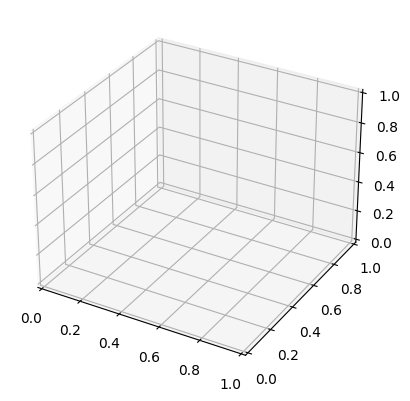

In [28]:
mesh_x, mesh_y = np.meshgrid(data.H, data.rho)

fig = plt.figure()

f, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figwidth(10)
fig.set_figheight(5)

surf = ax.plot_surface(mesh_x, mesh_y, err, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('H')
ax.set_ylabel('Eta')
ax.set_title('Model error')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

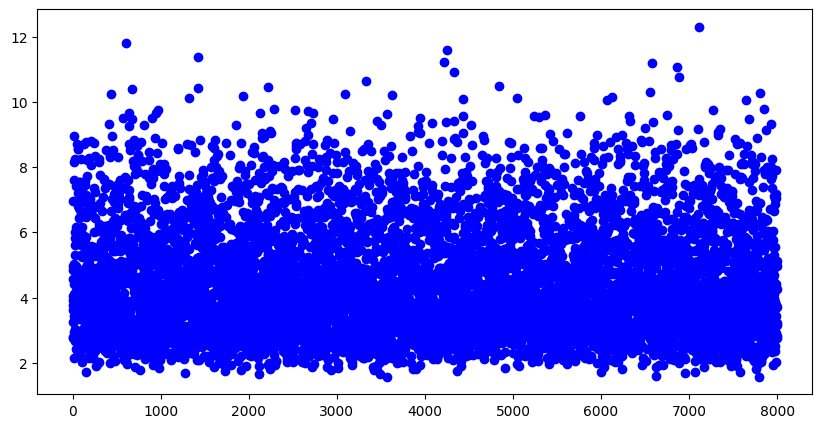

In [30]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(5)

plt.plot(err, 'bo')

In [31]:
param[np.argmin(err)]

array([-0.87627012,  0.07173147,  2.03800139])

In [32]:
H = np.array(data.H)
eta = np.array(data.eta)
rho = np.array(data.rho)

Eta: 1.7598418467534303


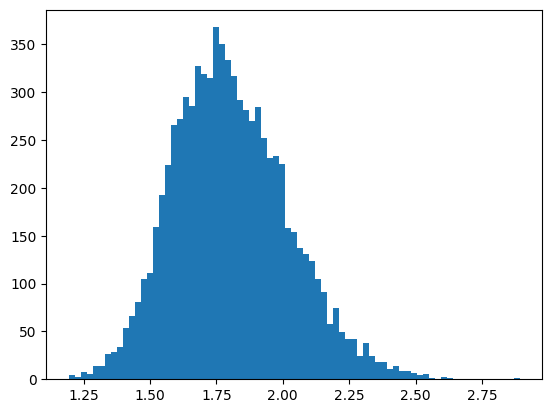

In [38]:
a = plt.hist(eta, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Eta:", x_max)